## Инициализация

In [1]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import meep.adjoint as mpa
import autograd.numpy as npa
from autograd import tensor_jacobian_product, grad
mp.verbosity(0)

'''Физические параметры'''
Si = 3.4
air = 1
wl = 1.1 # central wavelength (micron)
fcen = 1/wl #central frequency
df = 0.1 # pulse width (in frequency)
r = wl/(Si*2*np.pi) * 16 # disk radius

angle_list = np.linspace(0, 60, 5) # угол между краями углубления и центром диска (градусы)
distance_list = np.linspace(0.01, 0.5, 5) # расстояние между краями диска и волновода (микроны)
wg_width = 0.5 # waveguide width (micron)
wg_center_y_f = lambda a, d: (r+d)*np.sqrt(np.cos(np.radians(a))) + wg_width/2

'''Параметры симуляции'''
time = 600 # время симуляции после затухания источника
# Если время слишком маленькое, Harminv дает отрицательные Q
resolution = 50 # количество пикселей на один микрон
pad = 2 # padding between waveguide and edge of PML
pml_thickness = 0.5  # thickness of PML
nfreq = 100 # количество частот для подсчета мощности

sxy = int(2*(r + pad + 2*pml_thickness))  # cell size
wg_size = mp.Vector3(sxy, wg_width, 0)
src_center = mp.Vector3(-0.9*r) # Координата источника
flux_coord = r + pad - 0.1 # flux size and flux coordinate (удаленно от pml на 0.1 мкм)

'''Harminv мониторы'''
monitors = [mp.Vector3(0), 
            mp.Vector3(0.25*r), 
            mp.Vector3(0.5*r), 
            mp.Vector3(0.75*r),
            mp.Vector3(1*r),
            mp.Vector3(1.25*r)]

monitors_names = ['Центр диска', 
                  '0.25r', 
                  '0.5r', 
                  '0.75r', 
                  'r',
                  '1.25r']

harminv_monitors = [mp.Harminv(mp.Ez, mon, fcen, df) for mon in monitors]


'''Инициализация'''
def init_geometry(has_wg, angle=None, distance=None):
    if has_wg:
        wg_center = mp.Vector3(0, wg_center_y_f(angle,distance), 0)
        geometry = [
            mp.Block(size=wg_size, center=wg_center, material=mp.Medium(index=Si)), # волновод
            mp.Cylinder(radius=r, center=(0, distance, 0), material=mp.Medium(index=air)), # вырез в волноводе
            mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
        ] 
    else:
        geometry = [
        mp.Cylinder(radius=r, center=(0, 0, 0), material=mp.Medium(index=Si)), # диск  
        ] 
    return geometry



src = [mp.Source(mp.GaussianSource(frequency=fcen, fwidth=df), 
                 mp.Ez, 
                 center = src_center,
                 size = mp.Vector3(0))
]

sim = mp.Simulation(
    cell_size=mp.Vector3(sxy, sxy),
    sources=src,
    resolution=resolution,
    boundary_layers=[mp.PML(pml_thickness)],
    default_material=mp.Medium(index=air)
)
# Переменные для сохранения результатов
HARMINV_RES = {}
FLUX_RES = {}

## Без волновода

FloatProgress(value=0.0, description='0% done ', max=700.0)

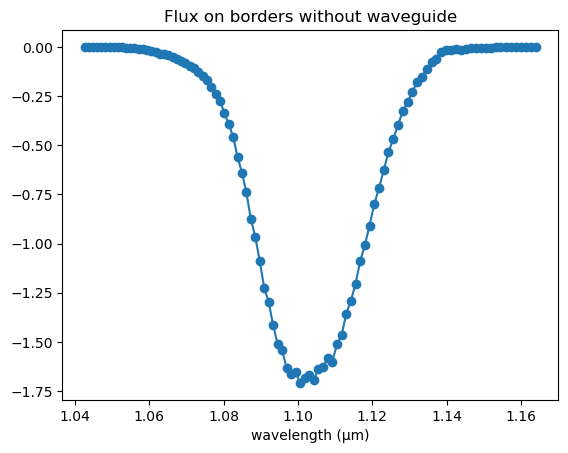

In [2]:

id_name = 'Без волновода'
# Create geometry
sim.geometry = init_geometry(has_wg=False)
sim.reset_meep()

# Add flux monitors
fluxes = [mp.FluxRegion(center=mp.Vector3(0, -flux_coord), size=mp.Vector3(2*flux_coord, 0)),
         mp.FluxRegion(center=mp.Vector3(flux_coord, 0), size=mp.Vector3(0, 2*flux_coord)),
         mp.FluxRegion(center=mp.Vector3(0, flux_coord), size=mp.Vector3(2*flux_coord, 0)),
         mp.FluxRegion(center=mp.Vector3(-flux_coord, 0), size=mp.Vector3(0, 2*flux_coord))]

borders_flux = sim.add_flux(fcen, df, nfreq, *fluxes)

# Run simulation
sim.run(mp.after_sources(*harminv_monitors),
        until_after_sources=time)


# Резонансные частоты и добротности 
res_freqs = []
Qs = []
for h in harminv_monitors:
    res_freqs.append([1/m.freq for m in h.modes])
    Qs.append([m.Q for m in h.modes])

HARMINV_RES[id_name] = {}
for name, h, q in zip(monitors_names, res_freqs, Qs):
    HARMINV_RES[id_name][name] = {'wavelengths': h, 'Qs': q}

# Fluxes
flux_freqs = np.array(mp.get_flux_freqs(borders_flux))
flux_on_borders = np.array(mp.get_fluxes(borders_flux))
sim.save_flux(f'{id_name}_flux', borders_flux) # Сохраняем в файл .h5

plt.figure()
plt.title("Flux on borders without waveguide")
plt.plot(1/flux_freqs, flux_on_borders, 'o-')
plt.xlabel("wavelength (μm)")
plt.savefig(f'{id_name}_flux.png')
plt.show()

## Перебор углов и зазоров

1. Построение геометрии (с волноводом)
2. Добавление мониторов
3. Прогон
4. Запись результатов

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 0.0 Расстояние 0.01


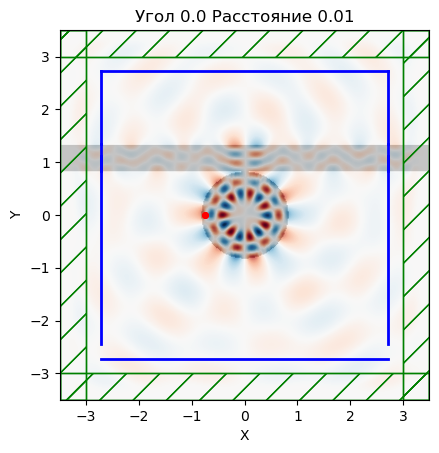

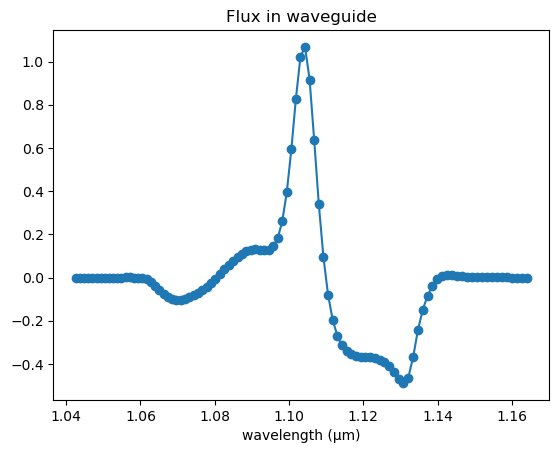

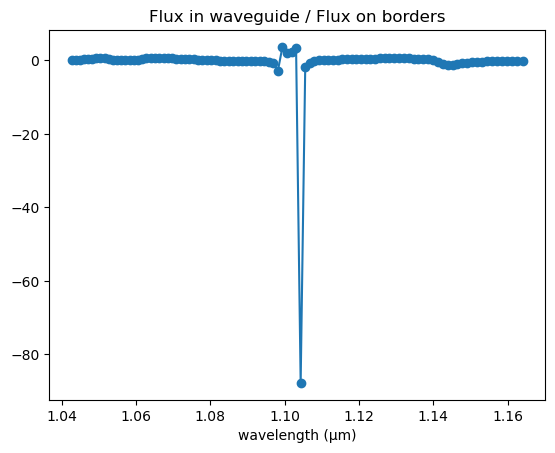

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 0.0 Расстояние 0.1325


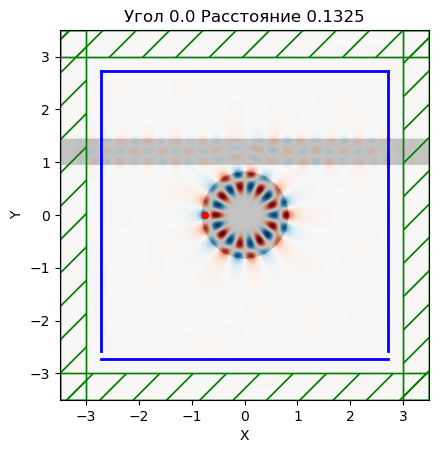

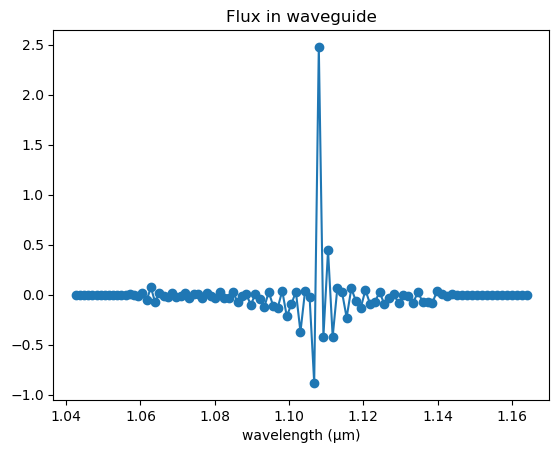

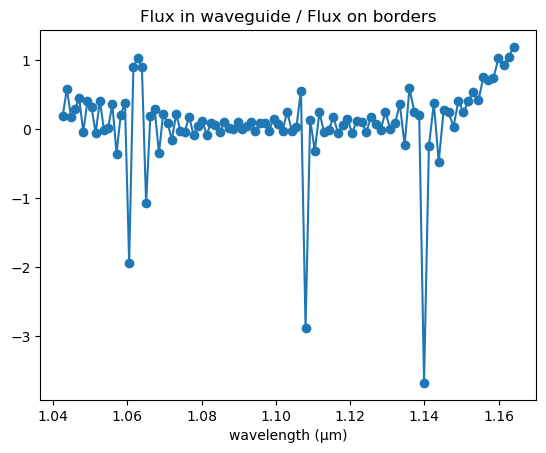

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 0.0 Расстояние 0.255


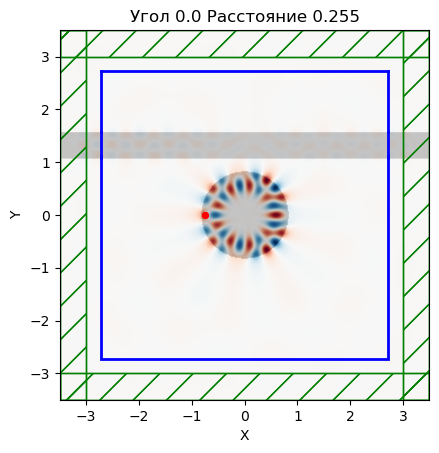

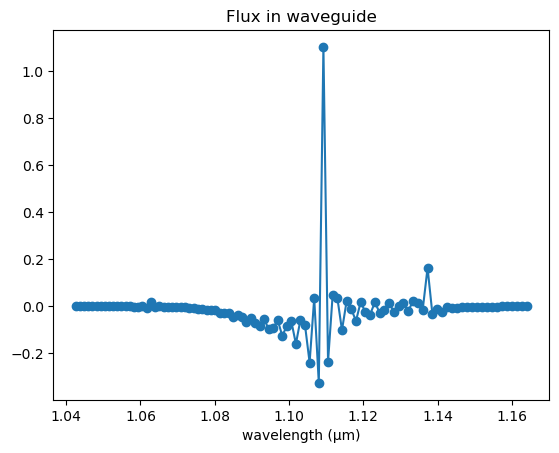

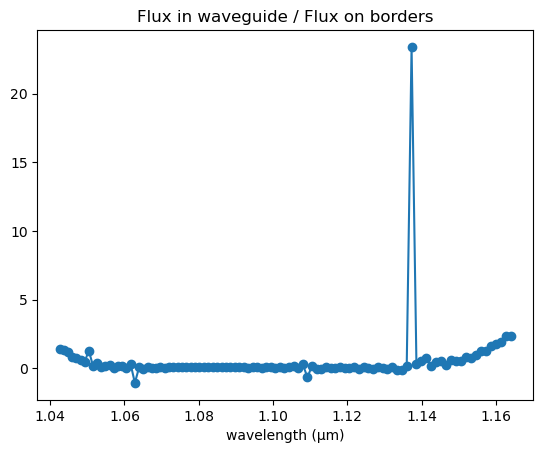

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 0.0 Расстояние 0.3775


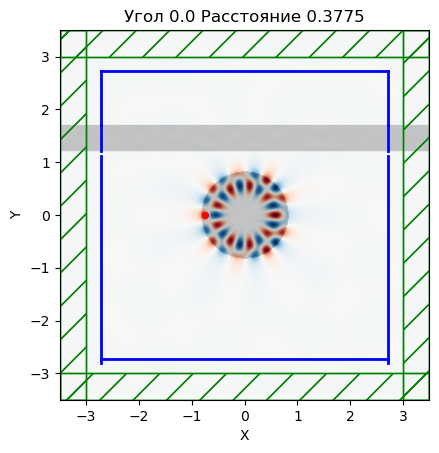

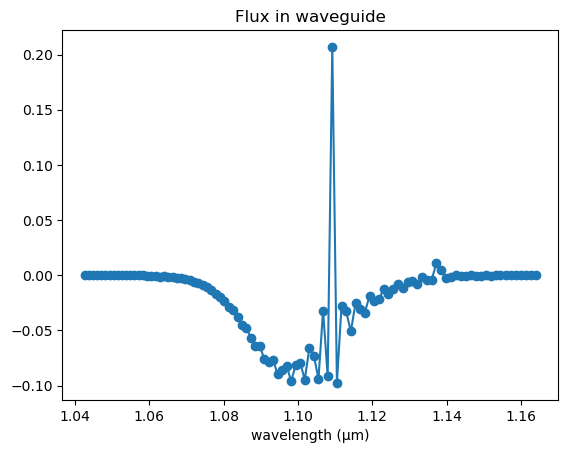

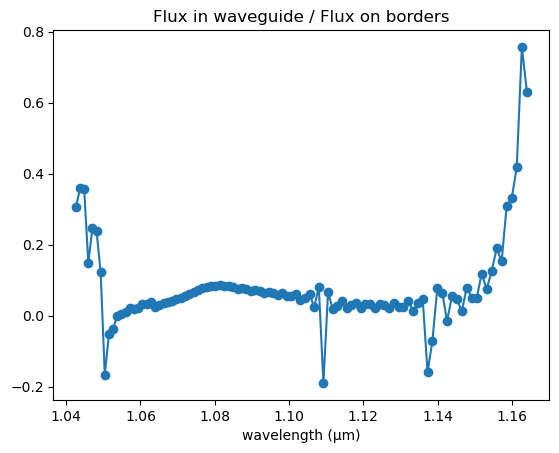

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 0.0 Расстояние 0.5


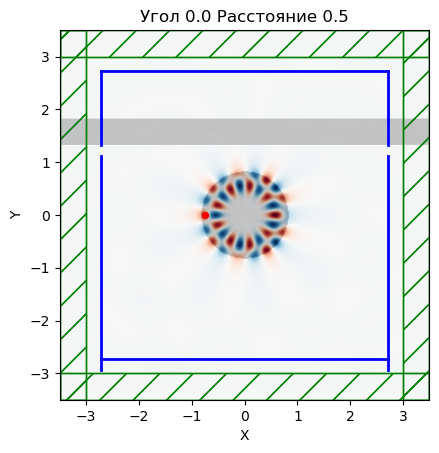

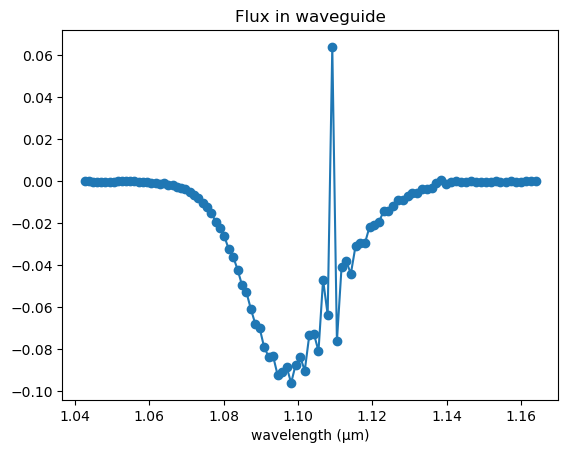

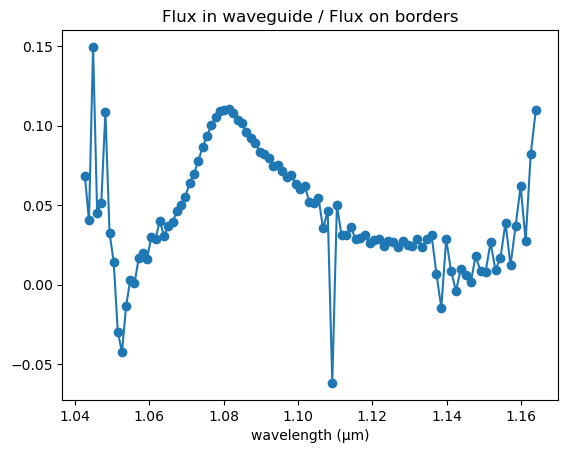

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 15.0 Расстояние 0.01


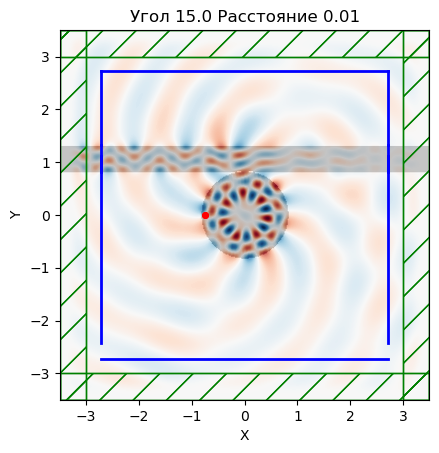

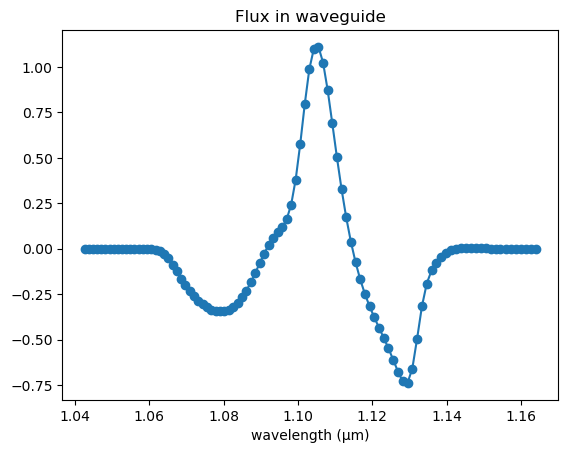

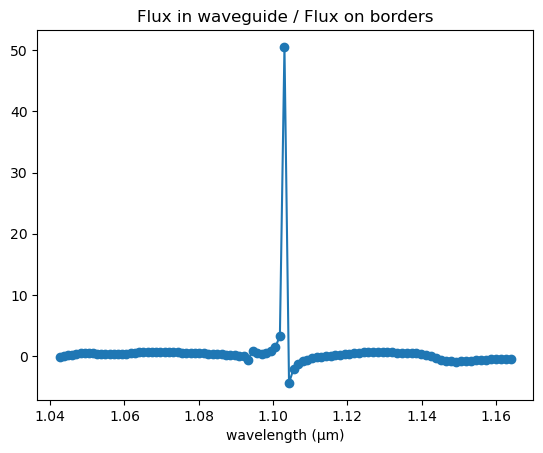

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 15.0 Расстояние 0.1325


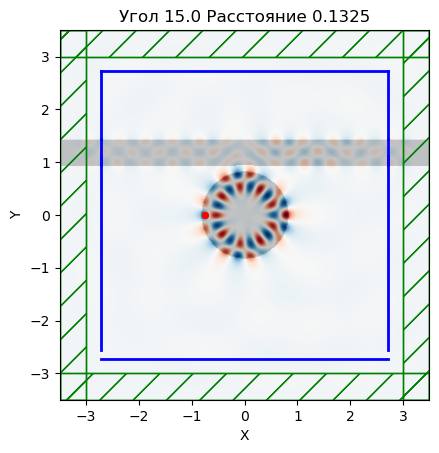

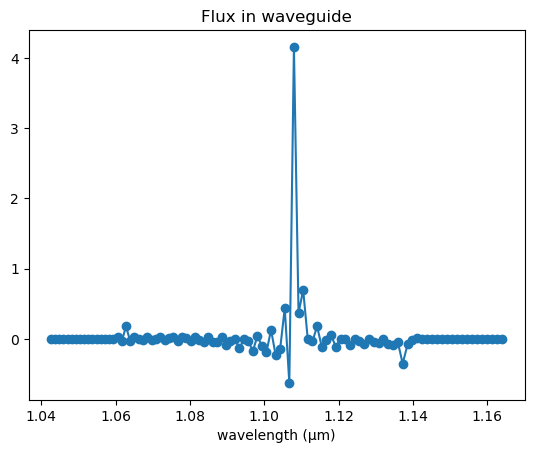

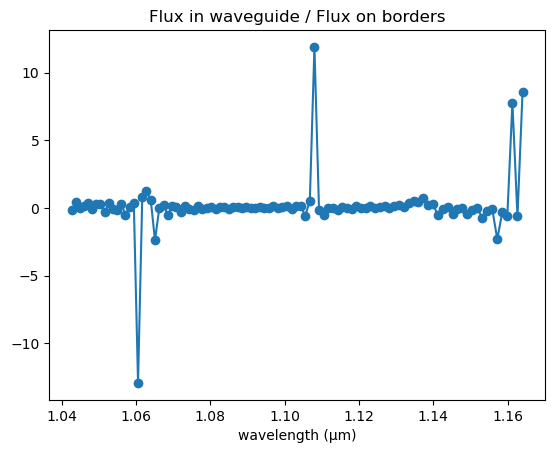

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 15.0 Расстояние 0.255


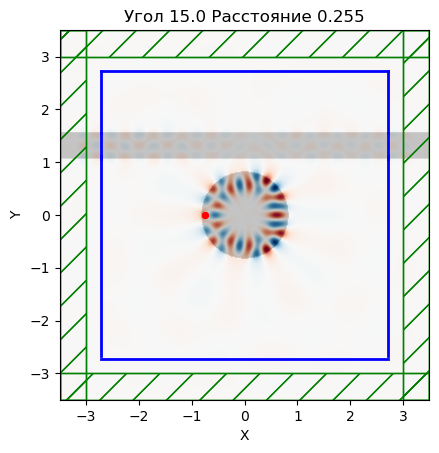

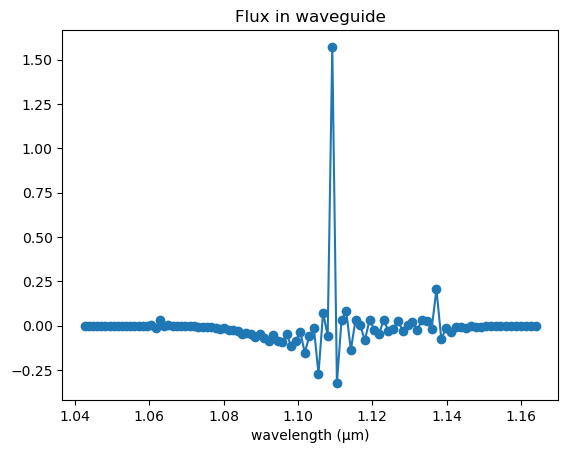

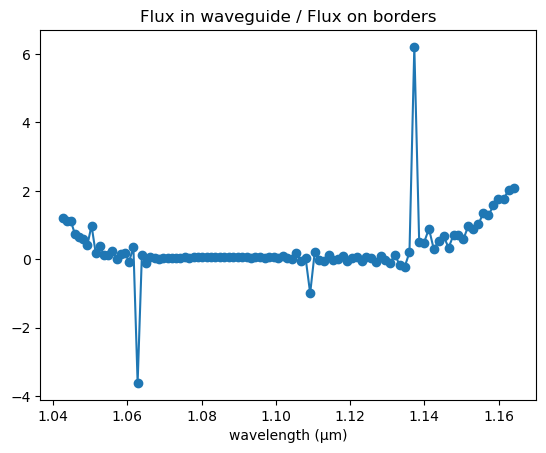

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 15.0 Расстояние 0.3775


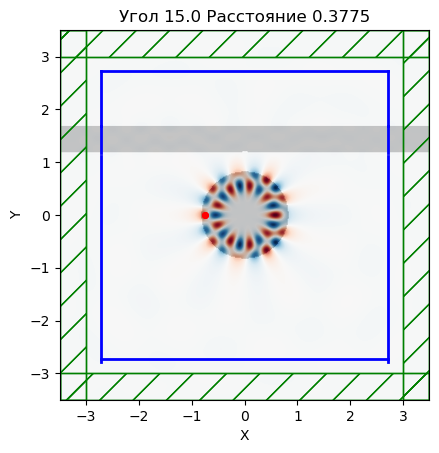

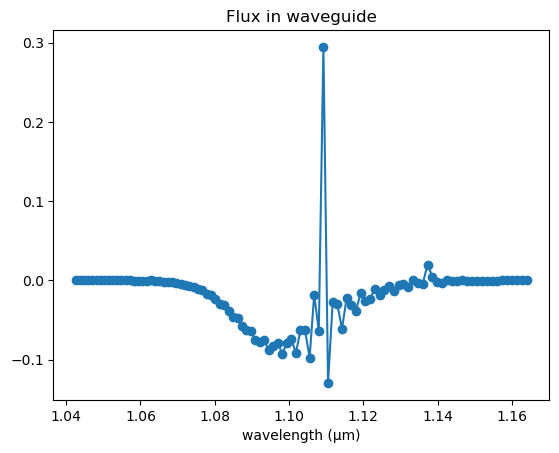

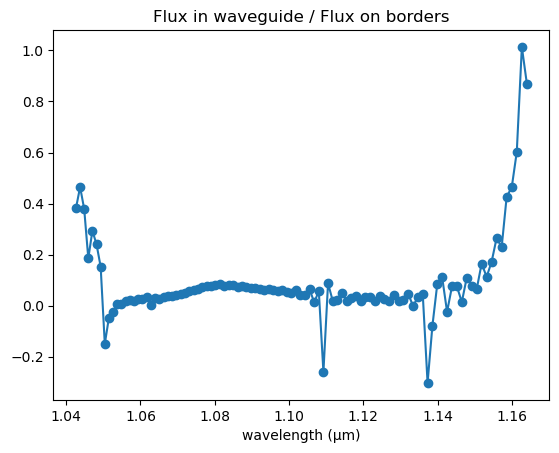

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 15.0 Расстояние 0.5


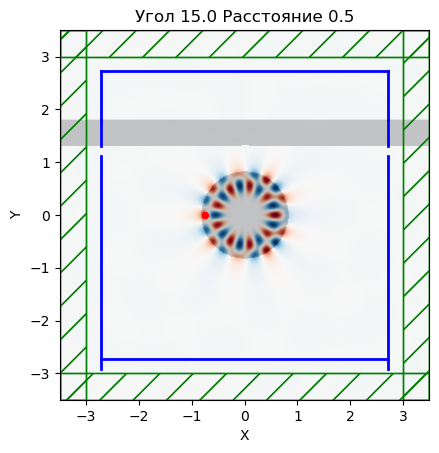

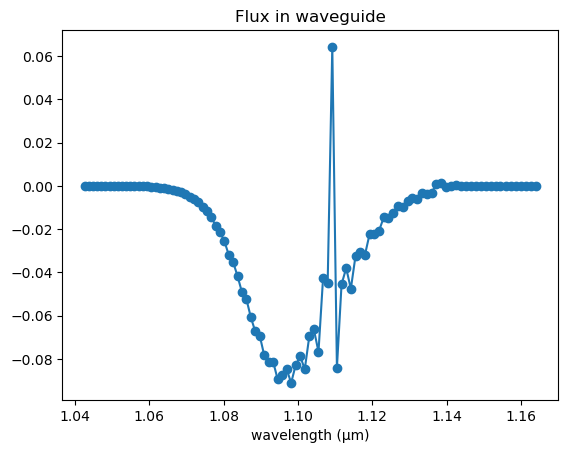

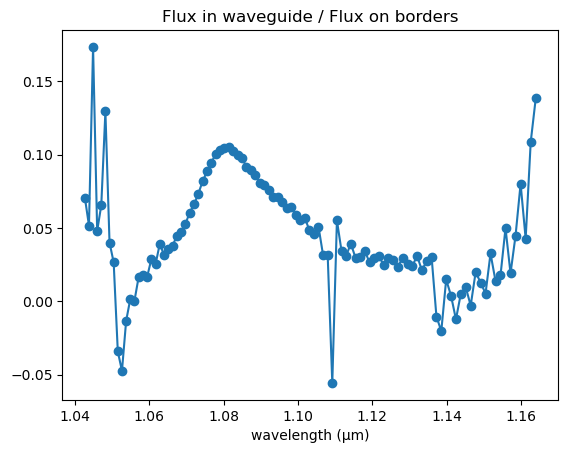

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 30.0 Расстояние 0.01


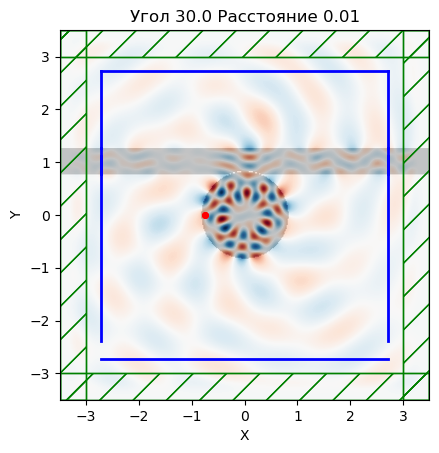

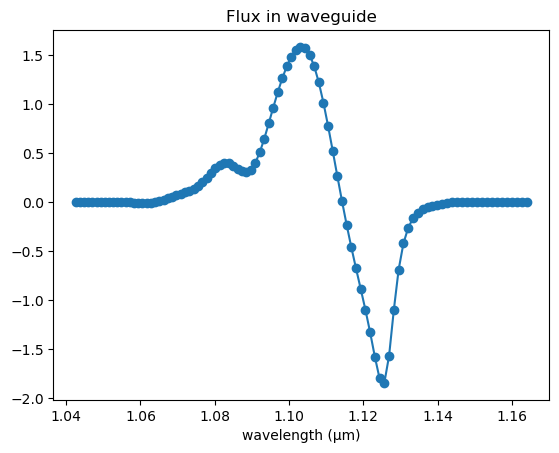

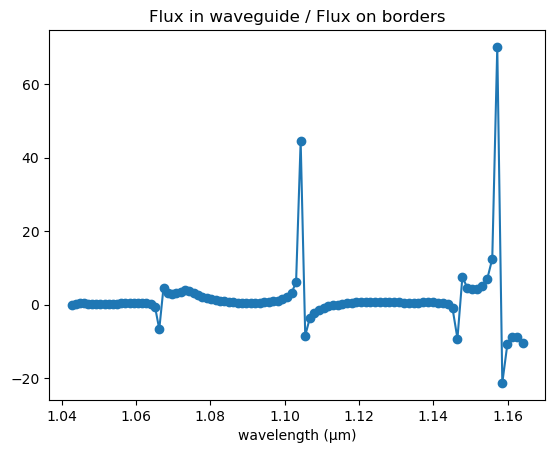

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 30.0 Расстояние 0.1325


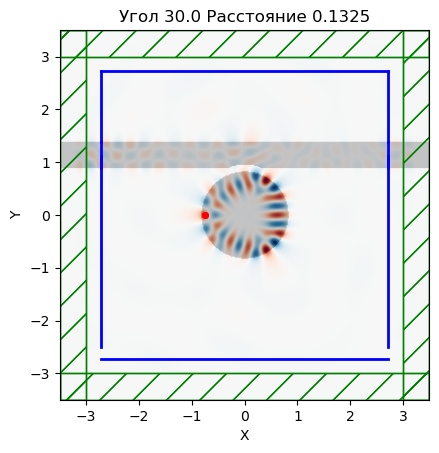

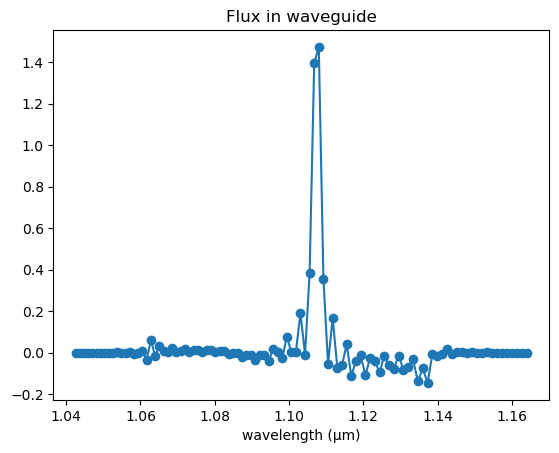

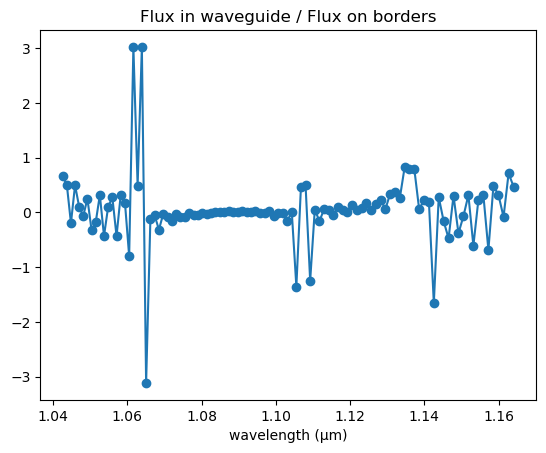

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 30.0 Расстояние 0.255


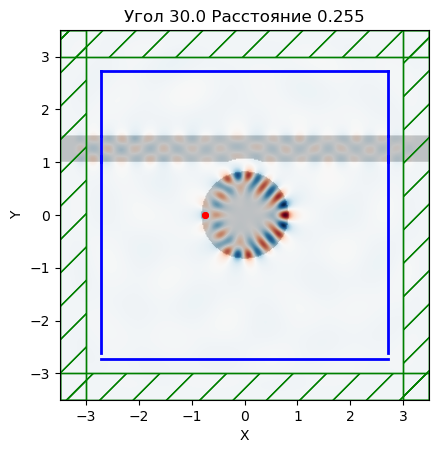

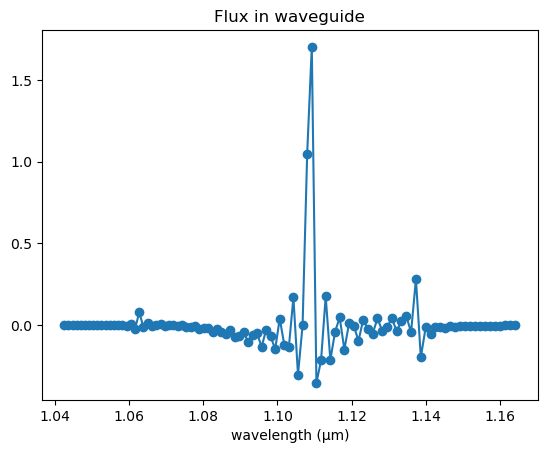

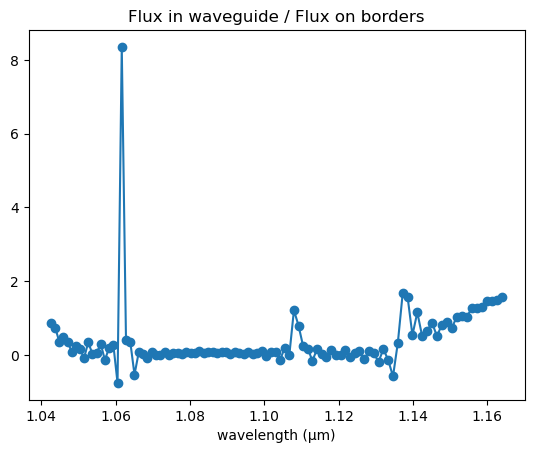

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 30.0 Расстояние 0.3775


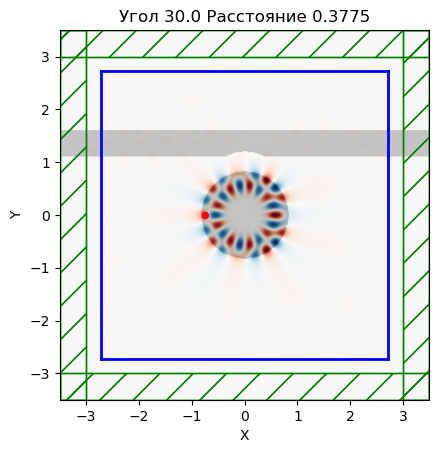

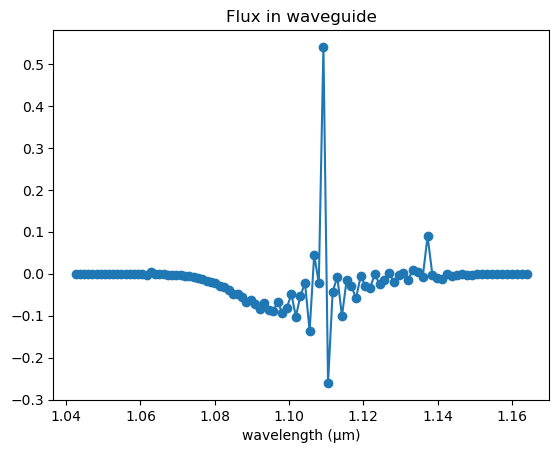

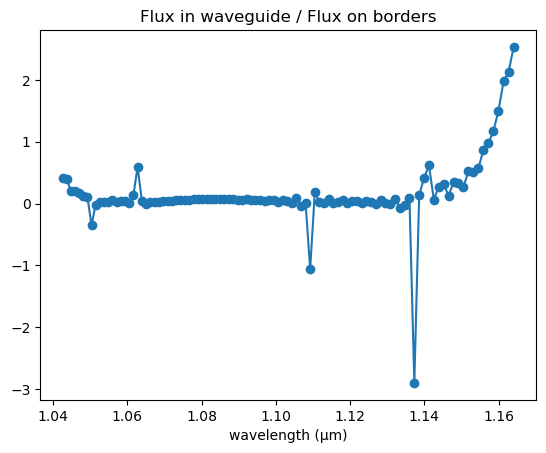

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 30.0 Расстояние 0.5


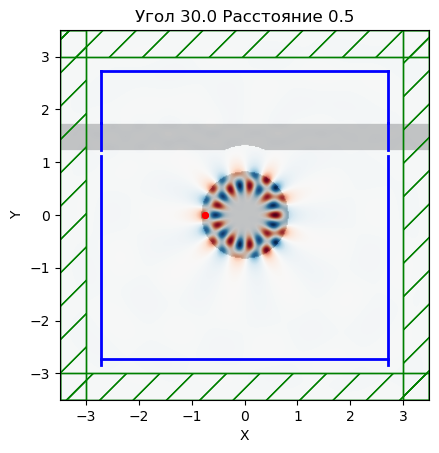

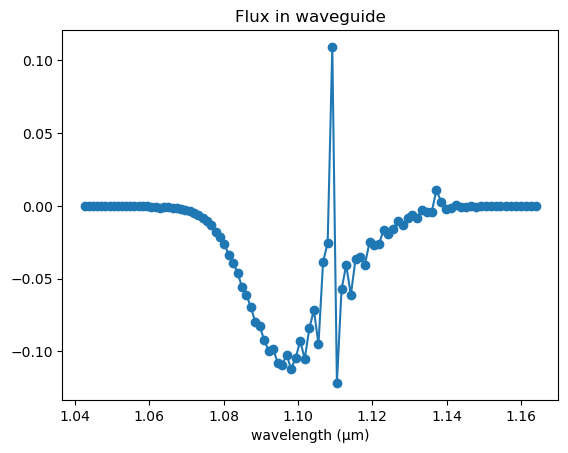

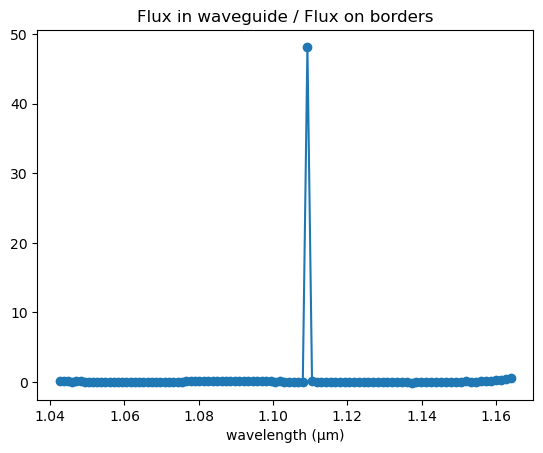

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 45.0 Расстояние 0.01


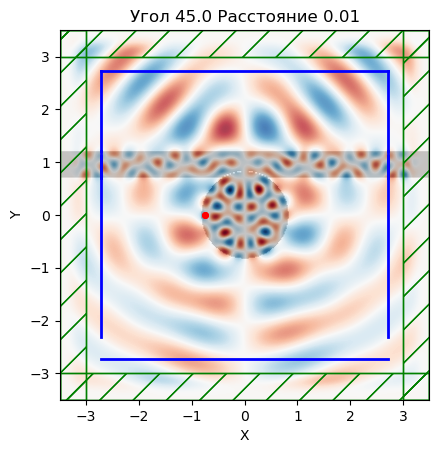

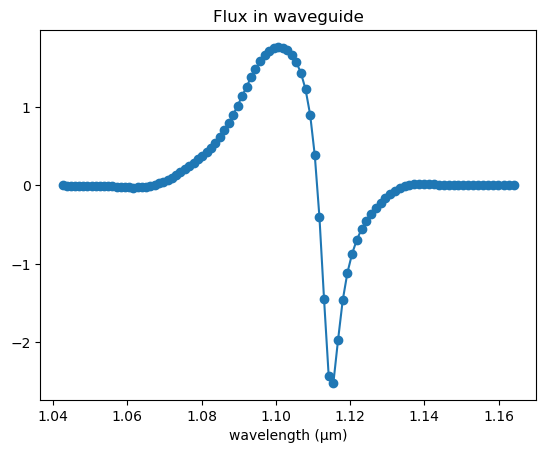

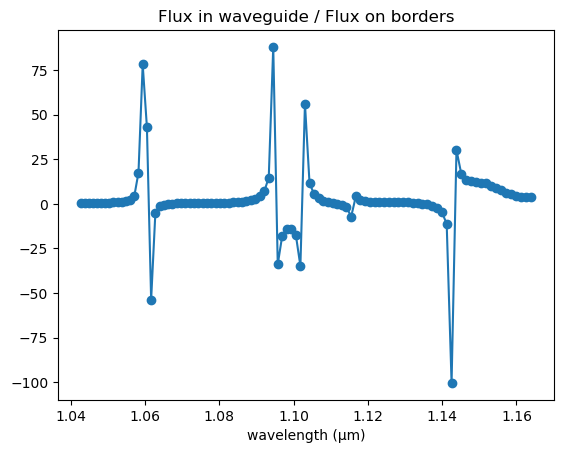

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 45.0 Расстояние 0.1325


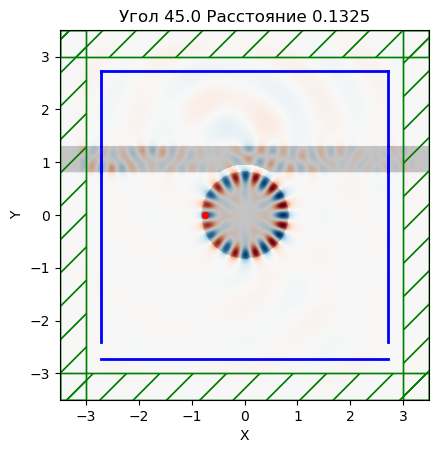

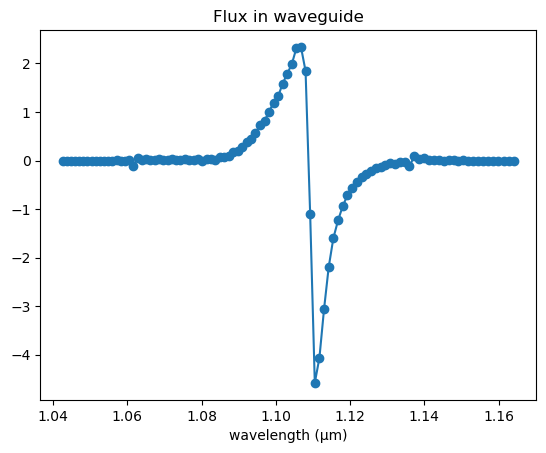

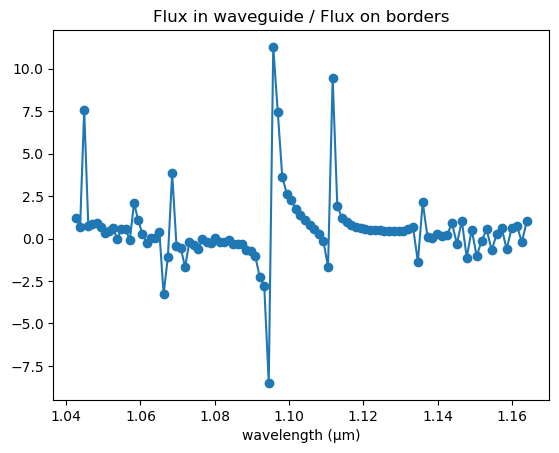

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 45.0 Расстояние 0.255


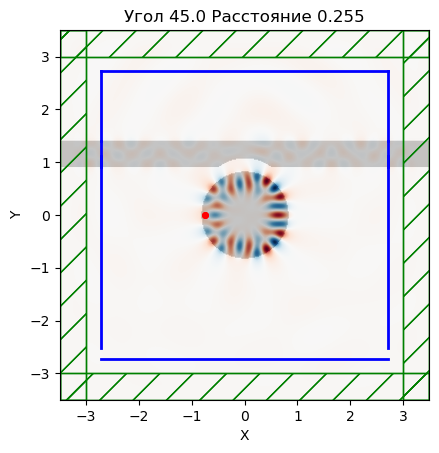

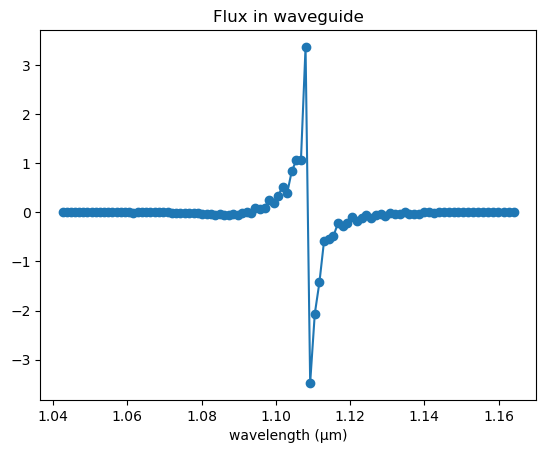

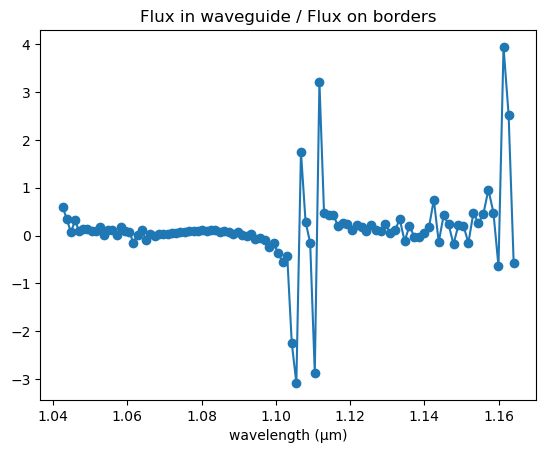

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 45.0 Расстояние 0.3775


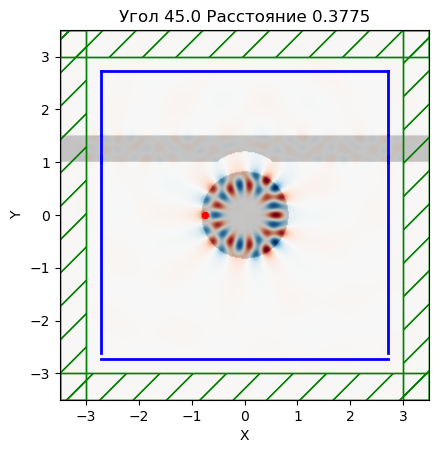

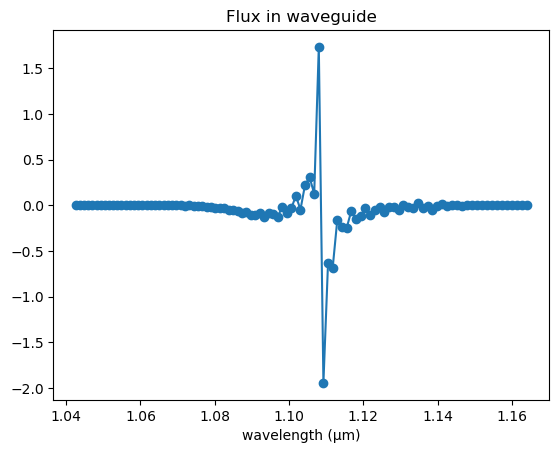

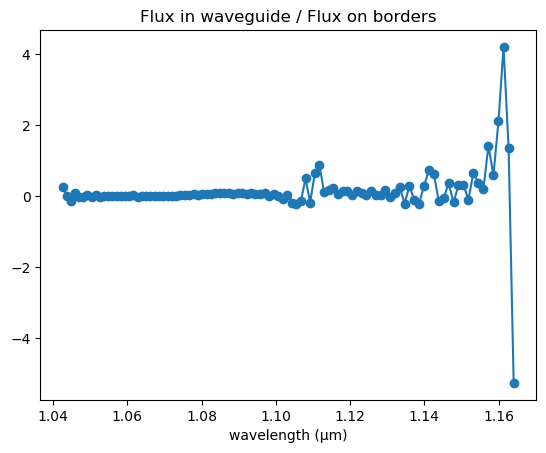

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 45.0 Расстояние 0.5


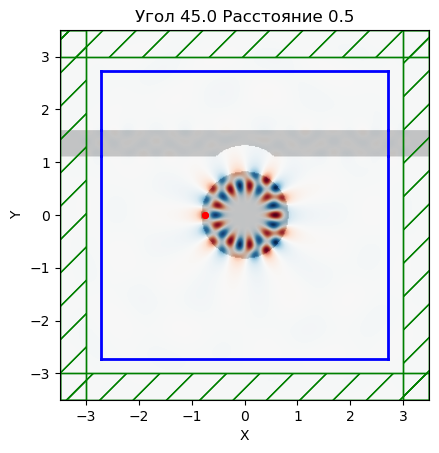

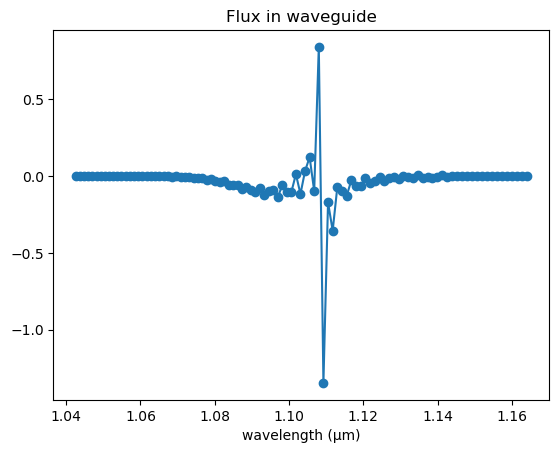

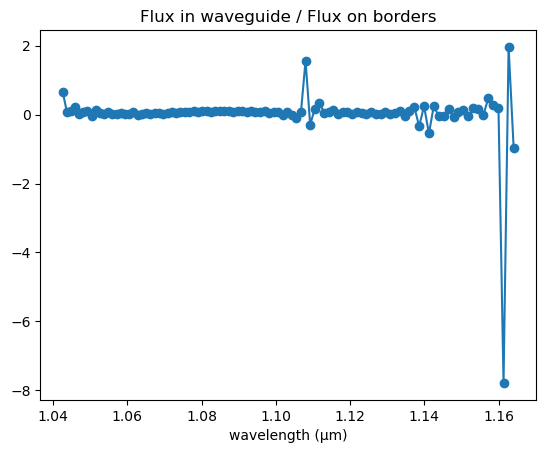

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 60.0 Расстояние 0.01


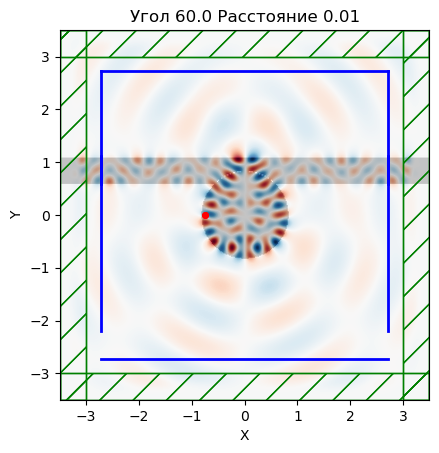

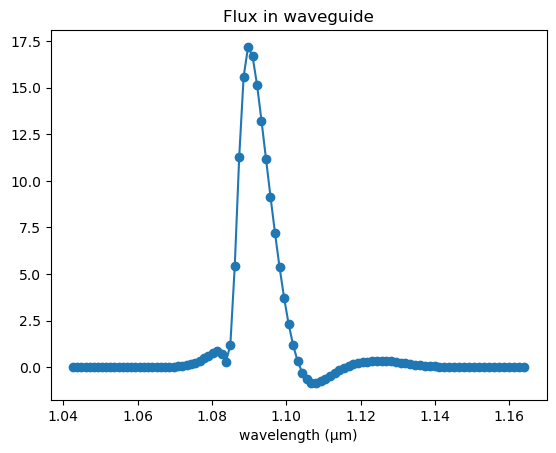

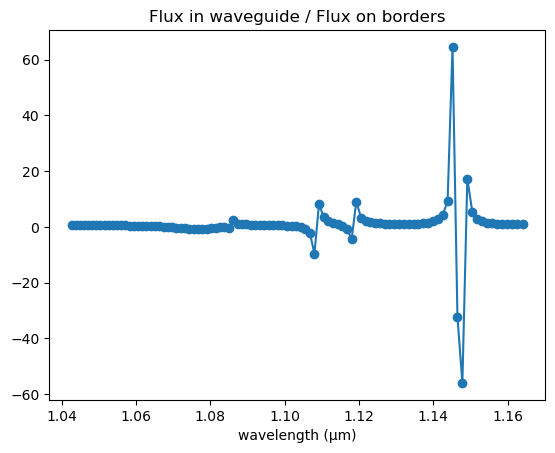

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 60.0 Расстояние 0.1325


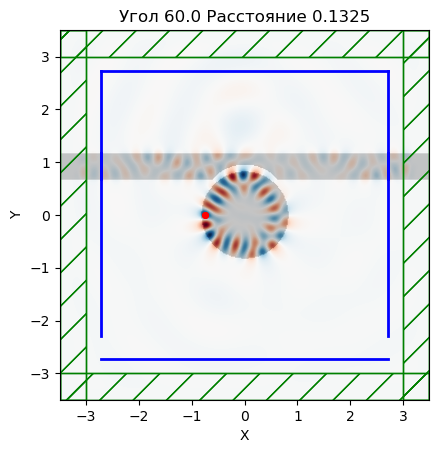

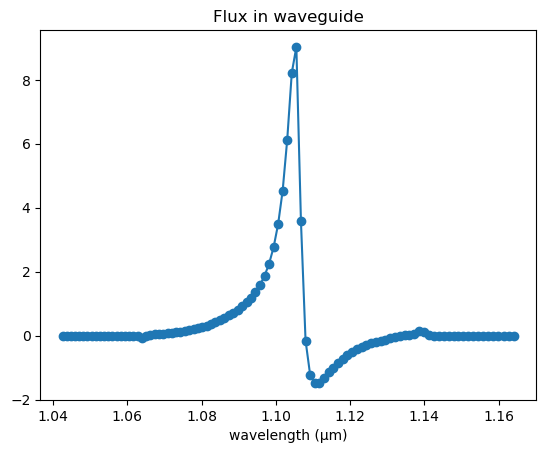

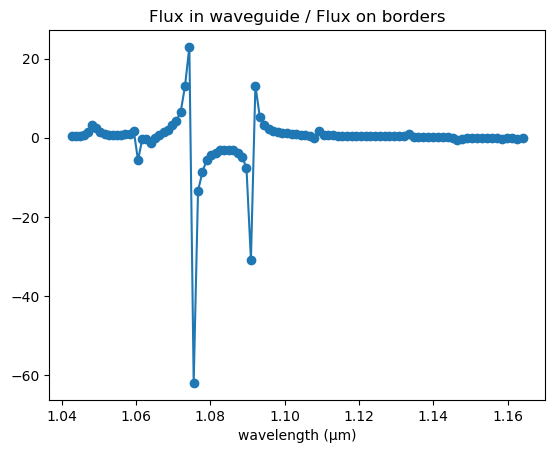

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 60.0 Расстояние 0.255


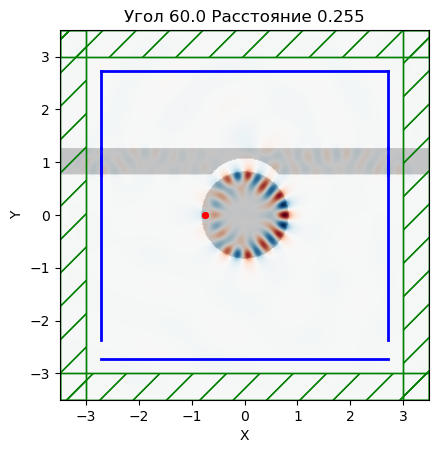

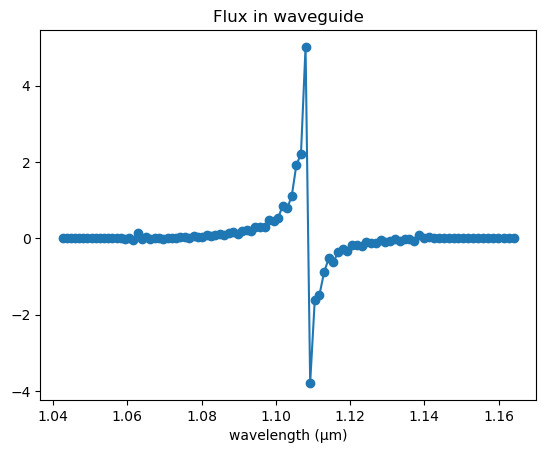

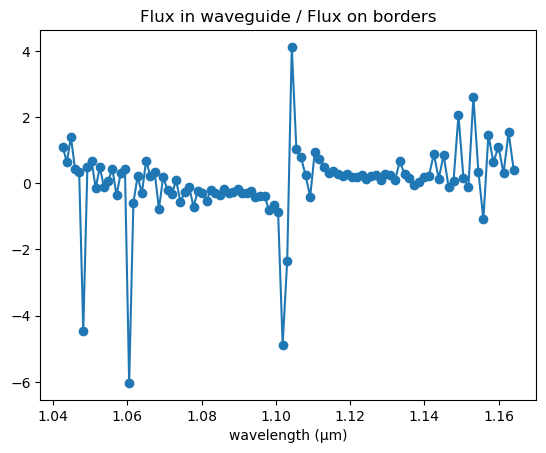

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 60.0 Расстояние 0.3775


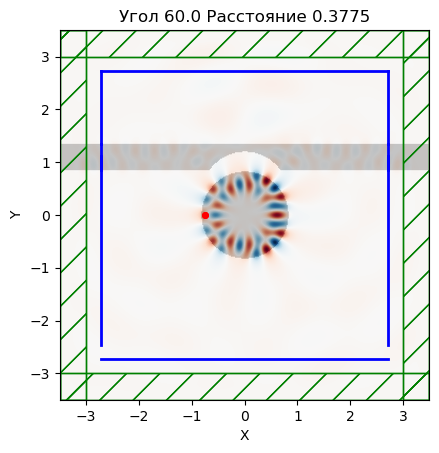

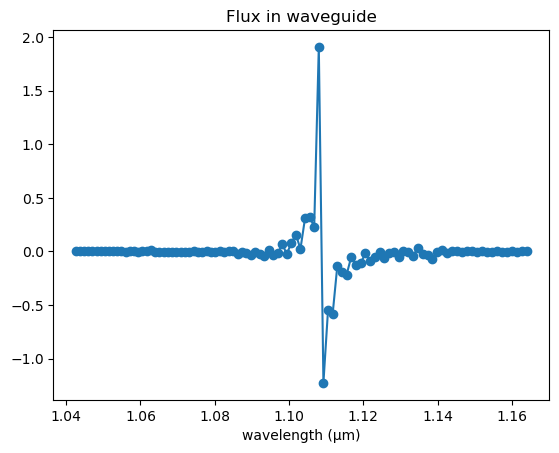

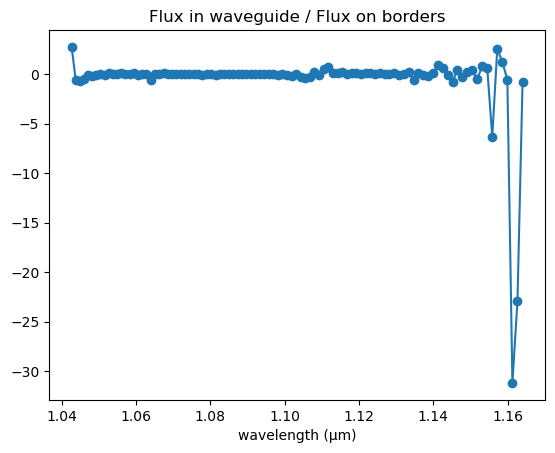

FloatProgress(value=0.0, description='0% done ', max=700.0)

Прогон для: Угол 60.0 Расстояние 0.5


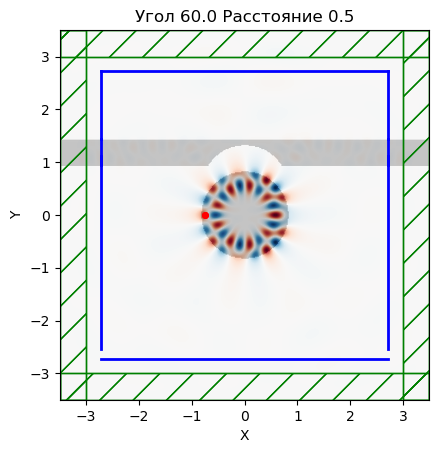

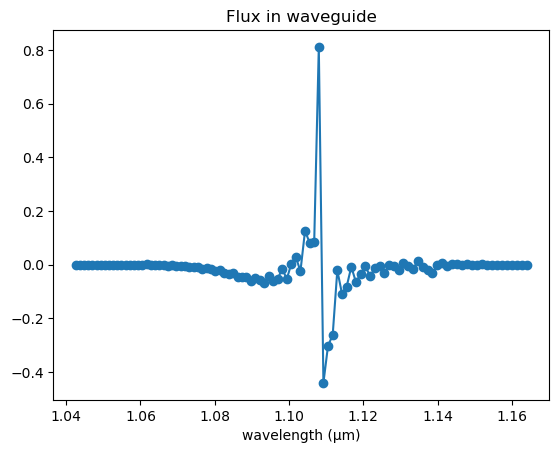

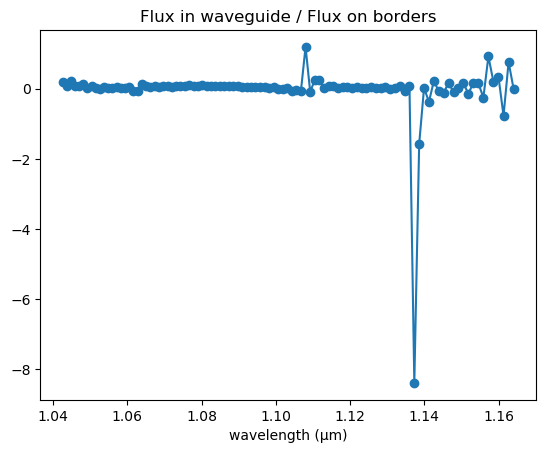

In [3]:
for angle in angle_list:
    for distance in distance_list:
        id_name = f'Угол {angle} Расстояние {distance}'
        #print(id_name)
        wg_center_y = wg_center_y_f(angle,distance)
        sim.geometry = init_geometry(has_wg=True, angle=angle, distance=distance)
        sim.reset_meep()
        sim.plot2D()
        plt.savefig(f'{id_name}_geom.png')
        #plt.show()

        # Add fluxes
        
        wg_fluxes_reg = [mp.FluxRegion(center=mp.Vector3(flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),
                    mp.FluxRegion(center=mp.Vector3(-flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),]
        
        size_bottom = flux_coord + wg_center_y - wg_width/2
        coord_bottom = -flux_coord/2 + (flux_coord-wg_center_y - wg_width/2)/2
        size_top = flux_coord  - wg_center_y - wg_width/2
        coord_top = (flux_coord + wg_center_y + wg_width/2)/2
        
        not_wg_fluxes_reg = [mp.FluxRegion(center=(flux_coord, coord_bottom,0), size=(0, size_bottom,0)), #right down
                        mp.FluxRegion(center=(flux_coord, coord_top,0), size=(0, size_top,0)), #right up
                        mp.FluxRegion(center=(-flux_coord, coord_bottom,0), size=(0, size_bottom,0)), #left down
                        mp.FluxRegion(center=(-flux_coord, coord_top,0), size=(0, size_top,0)), #left up
                        mp.FluxRegion(center=(0, -flux_coord,0), size=(2*flux_coord, 0,0)), #bottom
                        mp.FluxRegion(center=(0, flux_coord,0), size=(2*flux_coord, 0,0)), #top
                 ]
        wg_fluxes = sim.add_flux(fcen, df, nfreq, *wg_fluxes_reg)
        not_wg_fluxes = sim.add_flux(fcen, df, nfreq, *not_wg_fluxes_reg)
        
        # Run
        sim.run(mp.after_sources(*harminv_monitors), until_after_sources=time)
        print(f'Прогон для: {id_name}')
        # Image save
        sim.plot2D(fields=mp.Ez)
        plt.title(id_name)
        plt.savefig(f'{id_name}_geom.png')
        
        #Harminv save
        # Резонансные частоты и добротности для каждой моды каждой точки
        res_freqs = []
        Qs = []
        for h in harminv_monitors:
            res_freqs.append([1/m.freq for m in h.modes])
            Qs.append([m.Q for m in h.modes])
        
        HARMINV_RES[id_name] = {}
        for name, h, q in zip(monitors_names, res_freqs, Qs):
            HARMINV_RES[id_name][name] = {'wavelengths': h, 'Qs': q}

        #Flux save
        FLUX_RES[id_name] = {}
        flux_wls = 1 / np.array(mp.get_flux_freqs(not_wg_fluxes)) # частоты 
        flux_in_wg = np.array(mp.get_fluxes(wg_fluxes)) # внутри волновода 
        flux_out_wg = np.array(mp.get_fluxes(not_wg_fluxes)) # вне волновода
        sim.save_flux(f'{id_name}_flux_in', wg_fluxes) # Сохраняем в файл .h5
        sim.save_flux(f'{id_name}_flux_out', not_wg_fluxes) # Сохраняем в файл .h5
        
        FLUX_RES[id_name]['Wavelengths'] = flux_wls
        FLUX_RES[id_name]['In waveguide'] = flux_in_wg
        FLUX_RES[id_name]['On borders'] = flux_out_wg
        FLUX_RES[id_name]['Ratio'] = flux_in_wg/flux_out_wg

        plt.figure()
        plt.title("Flux in waveguide")
        plt.plot(flux_wls, flux_in_wg, 'o-')
        plt.xlabel("wavelength (μm)")
        plt.savefig(f'{id_name}_flux_in_wg.png')
        plt.show()

        plt.figure()
        plt.title("Flux in waveguide / Flux on borders")
        plt.plot(1/flux_freqs, flux_in_wg/flux_out_wg, 'o-')
        plt.xlabel("wavelength (μm)")
        plt.savefig(f'{id_name}_flux_ratio.png')
        plt.show()


<Axes: xlabel='X', ylabel='Y'>

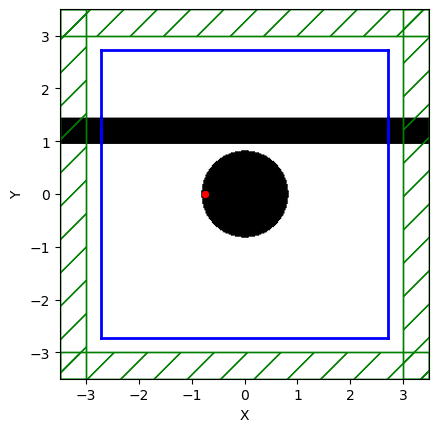

In [32]:
wg_center_y = wg_center_y_f(angle,distance)
sim.geometry = init_geometry(has_wg=True, angle=angle, distance=distance)
sim.reset_meep()
sim.plot2D()
plt.savefig(f'{id_name}_geom.png')
#plt.show()

# Add fluxes

wg_fluxes_reg = [mp.FluxRegion(center=mp.Vector3(flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),
            mp.FluxRegion(center=mp.Vector3(-flux_coord, wg_center_y), size=mp.Vector3(0,wg_width)),]

size_bottom = 2*flux_coord - wg_center_y - wg_width/2
coord_bottom = -flux_coord/2 + (flux_coord-wg_center_y - wg_width/2)/2
size_top = flux_coord  - wg_center_y - wg_width/2
coord_top = (flux_coord + wg_center_y + wg_width/2)/2

not_wg_fluxes_reg = [mp.FluxRegion(center=(flux_coord, coord_bottom,0), size=(0, size_bottom,0)), #right down
                mp.FluxRegion(center=(flux_coord, coord_top,0), size=(0, size_top,0)), #right up
                mp.FluxRegion(center=(-flux_coord, coord_bottom,0), size=(0, size_bottom,0)), #left down
                mp.FluxRegion(center=(-flux_coord, coord_top,0), size=(0, size_top,0)), #left up
                mp.FluxRegion(center=(0, -flux_coord,0), size=(2*flux_coord, 0,0)), #bottom
                mp.FluxRegion(center=(0, flux_coord,0), size=(2*flux_coord, 0,0)), #top
         ]
wg_fluxes = sim.add_flux(fcen, df, nfreq, *wg_fluxes_reg)
not_wg_fluxes = sim.add_flux(fcen, df, nfreq, *not_wg_fluxes_reg)

# Run
sim.plot2D()

## Визуализация

In [ ]:

sim.plot2D(fields=mp.Ez, field_parameters={'alpha':0.9, 'cmap':'RdBu'})
plt.savefig("microdisk.png")
plt.show()


In [ ]:
def animation(from_start, anim_time, filename):
    if from_start:
        sim.reset_meep()
    animate_sim = mp.Animate2D(fields=mp.Ez,
                           normalize = True,
                           field_parameters={'alpha':0.9, 'cmap':'RdBu'})
    
    sim.run(mp.at_every(1,animate_sim), until=anim_time)
    plt.close()
    animate_sim.to_gif(10, f"{filename}.gif")
    animate_sim.to_jshtml(10)


In [8]:
def plot_field_module(sim, size, center, show_material, filename):
    dielectric = sim.get_array(
        component=mp.Dielectric,
        size=size, center=center)
    dielectric = np.transpose(dielectric)
    
    Ex = sim.get_array(
        component=mp.Ex,
        size=size, center=center)
    Ey = sim.get_array(
        component=mp.Ey,
        size=size, center=center)
    Ez = sim.get_array(
        component=mp.Ez,
        size=size, center=center)
    
    # plotting
    fig, ax = plt.subplots()
    if show_material:
        ax.imshow(
            dielectric,
            cmap='binary',
            origin='lower'
            )
        
    im = ax.imshow(
        np.sqrt(np.abs(Ex)**2+np.abs(Ey)**2+np.abs(Ez)**2).T,
        origin='lower',
        alpha=1,
        cmap='RdBu'
        )
    
    plt.colorbar(im,label=r'$|E|$')
    ax.set_axis_off()
    plt.savefig(f"{filename}.png")

## Оптимизация

In [64]:
'''Optimization'''
minimum_length = 0.09
eta_e = 0.55
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e
design_region_resolution = int(resolution)
design_region_width = 2*r
design_region_height = wg_width + 2*distance
design_region_center = wg_center

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), mp.Medium(index=air), mp.Medium(index=Si), grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=design_region_center,
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

sim.geometry.append(mp.Block(center=design_region.center, size=design_region.size, material=design_variables)) # оптимизируемая зона

In [4]:
def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)
    
    # interpolate to actual materials
    return projected_field.flatten()


# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2, design_region_width / 2, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

circle_mask = (X_g**2 + Y_g**2 <= r)
wg_mask = (X_g == -design_region_width / 2) & (Y_g <= wg_width / 2)

# Define the core mask
'''left_wg_mask = (X_g == -design_region_width / 2) & (np.abs(Y_g) <= waveguide_width / 2)
top_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g + arm_separation / 2) <= waveguide_width / 2
)
bottom_right_wg_mask = (X_g == design_region_width / 2) & (
    np.abs(Y_g - arm_separation / 2) <= waveguide_width / 2
)'''
Si_mask = circle_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
air_mask = border_mask.copy()
air_mask[Si_mask] = False




In [5]:


field = mpa.FourierFields(
    sim,
    mp.Volume(
        center=src_center,
        size=mp.Vector3(0),
    ),
    component=mp.Ez
)

def J(field):
    return npa.mean(field)

ob_list = [field]
opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=J,
    objective_arguments=ob_list,
    design_regions=[design_region],
    fcen=fcen,
    df=df,
    nf=10,
    decay_by=1e-5,
)


Starting forward run...
[-0.34529019 -0.19075447j  0.41469552 +0.47032091j
 -0.44882027 -0.82796323j 30.81459987+18.85444082j
  0.38416196 +0.06266613j  0.37477586 +0.05080985j
 -0.59771874 -0.23603476j  0.45773817 +0.3572174j
 -0.23333752 -0.39323268j  0.03802967 +0.38650896j]
(3.085883432917698+1.8533978926739458j)


/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/masha/conda/envs/mp/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


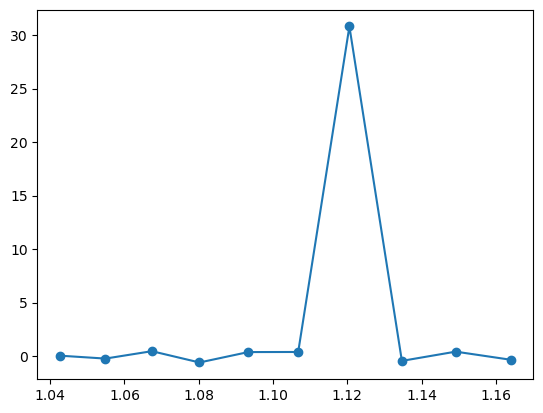

In [7]:
x = np.ones((Nx*Ny,)) * 0
f0, _ = opt([mapping(x, eta_i, 128)], need_gradient=False)
frequencies = opt.frequencies
[dftfld] = opt.get_objective_arguments()
plt.figure()
plt.plot(1 / frequencies, dftfld, "-o")
print(dftfld)
print(f0)


In [9]:

evaluation_history = []
cur_iter = [0]


def f(v, gradient, cur_beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    circ = Circle((2, 2), minimum_length / 2)
    ax.add_patch(circ)
    ax.axis("off")
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)